## Rename images

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import gc
import os.path as osp
import glob


# Specify the folder path
folder_path = r"images"


# Get all files in the folder
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Loop through and rename files
# for index, file in enumerate(files, start=1):
#     # Extract file extension
#     file_extension = os.path.splitext(file)[1]
    
#     # Create the new file name
#     new_file_name = f"HR_{index:04}{file_extension}"
#     # new_file_name = f"bandomasis{file_extension}"
    
#     # Full paths for rename
#     old_path = os.path.join(folder_path, file)
#     new_path = os.path.join(folder_path, new_file_name)
    
#     # Rename the file
#     os.rename(old_path, new_path)

print("Files renamed successfully!")


Files renamed successfully!


## Get images dimensions

In [2]:
def get_image_sizes():
    images = pd.DataFrame()
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for file in files:
        with Image.open('images\\'+file) as img:
            width, height = img.size  # Get dimensions

            image = {'name':file, 'width':width, 'height':height}
            images = pd.concat([images, pd.DataFrame([image])], ignore_index=True)
    return images

image_sizes = get_image_sizes()
image_sizes

,name,width,height
0,HR_0001.png,2040,1356
1,HR_0002.png,1608,1200
2,HR_0003.png,2040,1356
3,HR_0004.png,2040,1524
4,HR_0005.png,2040,1344
...,...,...,...
3545,HR_3546.png,2040,1356
3546,HR_3547.png,2040,1356
3547,HR_3548.png,2040,1152
3548,HR_3549.png,2040,1356


In [3]:
image_sizes.describe()

,width,height
count,3550.000000,3550.000000
mean,2022.338028,1368.638873
std,73.404361,159.517651
min,1536.000000,648.000000
25%,2040.000000,1344.000000
50%,2040.000000,1356.000000
75%,2040.000000,1368.000000
max,2040.000000,2040.000000


## Rotate vertical images

In [4]:
def rotate_image(file_name):
    with Image.open(f'images/'+file_name) as img:
        # Rotate the image by 90 degrees
        rotated_image = img.rotate(90, expand=True)

        # Save or display the rotated image
        rotated_image.save(f'images/'+file_name)
        print(f'{file_name} - rotate successfully!')
        
image_sizes = get_image_sizes()
vertical_images = image_sizes[image_sizes['width'] < image_sizes['height']]
vertical_images

,name,width,height


In [5]:
vertical_images['name'].apply(rotate_image)

Series([], Name: name, dtype: object)

In [37]:
# Define the SRCNN model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # Sumazeja (kernerl_size-1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        x4 = self.relu(self.conv4(x3))
        x5 = self.conv5(x4)
        return x5


In [28]:
def preprocess_image(image_path, scale_factor=4, method=Image.BICUBIC):
    high_res_image = Image.open(image_path).convert("YCbCr")
    # high_res_image = high_res_image.resize((high_res_image.width // scale_factor, high_res_image.height // scale_factor), method)
    y_high_res, _, _ = high_res_image.split()
    
    # Create low-resolution version of the Y channel
    low_res_image = high_res_image.resize((high_res_image.width // scale_factor, high_res_image.height // scale_factor), method)
    low_res_image = low_res_image.resize((high_res_image.width, high_res_image.height), method)

    y_low_res, cb_low_res, cr_low_res = low_res_image.split()  # Split into Y, Cb, Cr


    # Convert to tensors
    transform = transforms.ToTensor()
    y_high_res_tensor = transform(y_high_res)
    y_low_res_tensor = transform(y_low_res)

    return y_low_res_tensor, y_high_res_tensor, cb_low_res, cr_low_res  # Return Cb and Cr for reconstruction

In [8]:
# Define the training function
def train(model, criterion, optimizer, input_image, target_image, epochs=10):
    model = model.to('cuda')
    input_image = input_image.to('cuda')
    target_image = target_image.to('cuda')
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(input_image)
        loss = criterion(output, target_image)
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

In [38]:
model = SRCNN()
loss_f = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load and preprocess images
input_tensor, target_tensor, cb, cr = preprocess_image("example_hr.png")


In [10]:
del model
# del optimizer
# del loss_f
loss = None  # Reset loss
torch.cuda.empty_cache()  # Free GPU memory
gc.collect()

0

In [ ]:
train(model, loss_f, optimizer, input_tensor, target_tensor,10)

In [ ]:
# def save_image(image, file_name):
#     image = image.permute(1,2,0).numpy() ## Change to format height, width, channels
#     image = (image*255).astype('uint8')
#     print(image.shape)
#     if image.shape[2] == 1:
#         image = image.squeeze(2)
#     img_to_save = Image.fromarray(image)
#     img_to_save.save(file_name)
    
# # Save the output
# with torch.no_grad():
#     model = model.to('cpu')
#     output = model(input_tensor)
#     output_image = transforms.ToPILImage()(output[0])
#     # save_image(output[0], 'example_generated.png')

# output_image

In [23]:
def y_tensor_to_image(y_tensor:torch.Tensor, cb, cr):
    # Clamp output to valid range [0, 1] and convert to uint8
    output_y = y_tensor.squeeze(0).clamp(0, 1).numpy() * 255
    y = Image.fromarray(output_y.astype('uint8'), mode='L')

    # Combine enhanced Y channel with original Cb and Cr
    ycbcr = Image.merge("YCbCr", (y, cb, cr))

    # Convert to RGB
    output_image = ycbcr.convert("RGB")
    return output_image

def rgb_tensor_to_image(tensor:torch.Tensor,):
    # Clamp output to valid range [0, 1] and convert to uint8
    output = tensor.squeeze(0).clamp(0, 1).numpy() * 255
    image = Image.fromarray(output.transpose(1,2,0).astype('uint8'), mode='RGB')

    return image

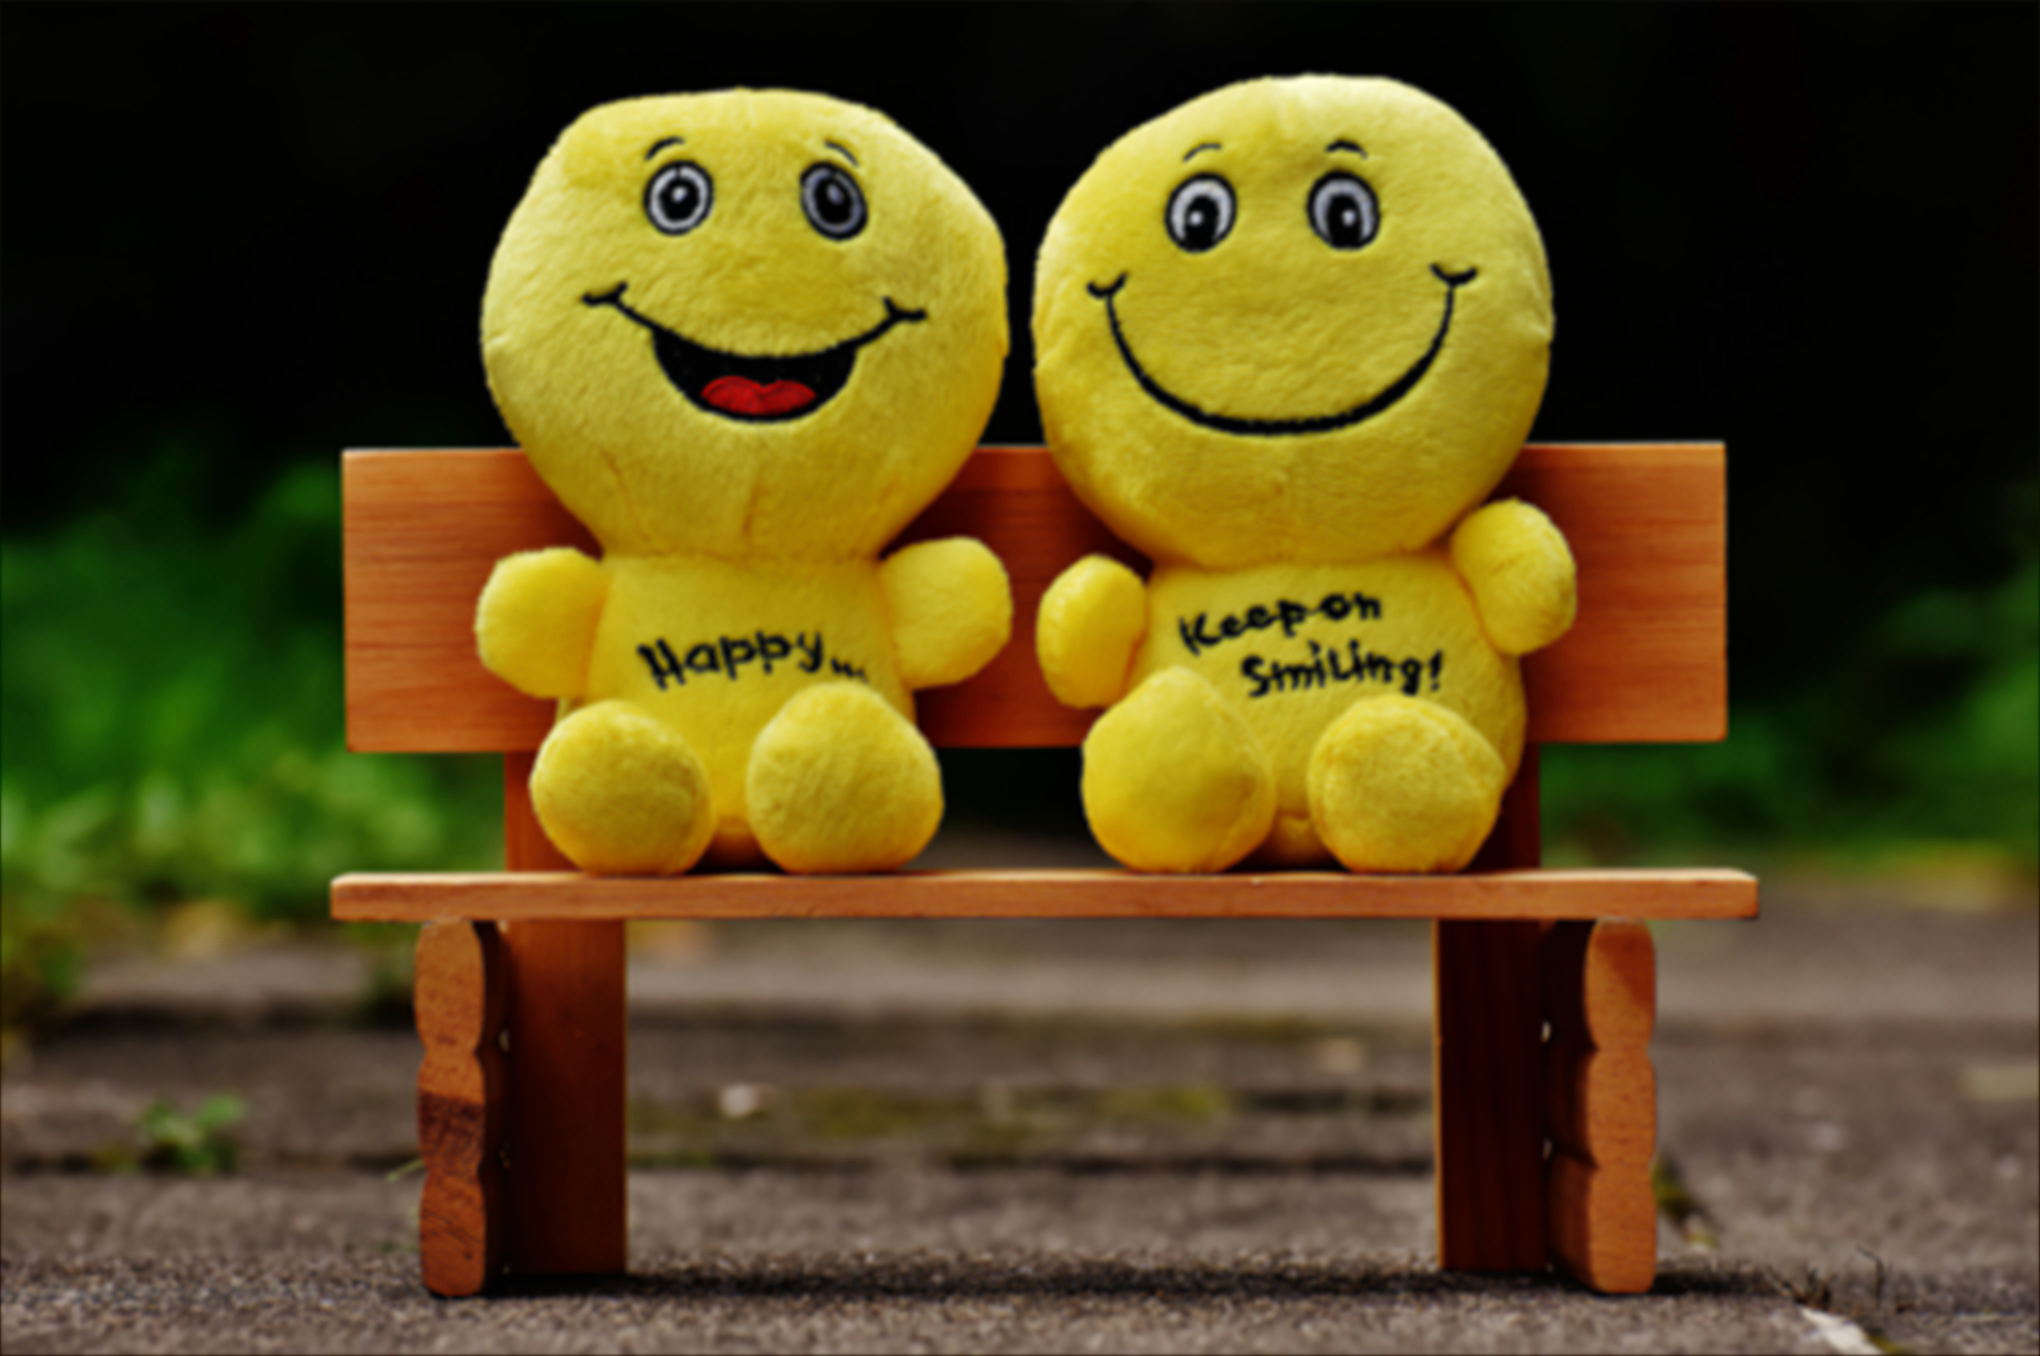

In [33]:
with torch.no_grad():
    model = model.to('cpu')
    output :torch.Tensor = model(input_tensor)
y_tensor_to_image(output, cb, cr)

In [ ]:
y_tensor_to_image(input_tensor, cb, cr)

In [ ]:
new_w = int(cb.width * 4)
new_h = int(cb.height * 4)

y_tensor_to_image(outputas.detach().squeeze(0), cb.resize((new_w, new_h)),cr.resize((new_w, new_h)))